Install and import packages

In [4]:
! pip install numpy
! pip install matplotlib
! pip install tqdm
! pip install sklearn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.model_selection import train_test_split

You should consider upgrading via the '/home/pjaworsk/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pjaworsk/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pjaworsk/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/pjaworsk/miniconda3/bin/python -m pip install --upgrade pip' command.


Create SOM class to initialize values and perform training
Notes for class:
- initialize weights from 0-1
- shuffle training data for each epoch

In [5]:
class SOM:
    def __init__(self, n_inputs, n_outputs, init_learn_rate, init_sigma=0, n_epochs=1000, seed=0):
        """
        Creates a symmetric nxn self organizing map using n_outputs as the dimensions
        All parametrs are set on startup such as epoch, learning rate, neighborhood sigma, prior to the
        initial training on the input data.

        The weight matrix for this map is initialized to small random values on startup

        Parameters
        ----------
        n_inputs: int
        number of input nodes
        n_outputs_x: int
            number output nodes in X and Y direction
        init_learn_rate: float
            the initial learning rate parameter which tapers off per epoch
        init_sigma : init (default 0)
            the initial Neighborhood value used to shrink update between epochs.
            Default = 0 (Winner take all strategy)
                =/= 0 (Cooperative Strategy)

        n_epochs: int
        the max amoutn of training epochs used for the output map.
        prev_state: class SOM
        Push the previous state of another similar sized mapped to this instance.
        """
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.init_learn_rate = init_learn_rate
        self.init_sigma = init_sigma
        self.n_epochs = n_epochs

        #intialize weights and other params that get adjusted during training should have a n_input x (n_output x n_output) tensor for our matrix
        weight_init_range = 1
        np.random.seed(seed)
        self.weights = np.random.uniform(0, weight_init_range, (self.n_inputs, self.n_outputs, self.n_outputs))
        self.neighbourhood_indices = np.zeros((2, n_outputs, n_outputs))
        for ii in range(0, self.n_outputs):
            for jj in range(0, self.n_outputs):
                self.neighbourhood_indices[:, ii, jj] = [ii, jj]



        # Keep a count of epoch as thats used to decay our neighborhood and learning rate
        # current_epoch as well as n_epochs is used to determine time with respect to epoch in the SOM
        self.current_epoch = 0

        #Set the current state to the initial learning rate
        self.learn_rate = init_learn_rate


    def get_distance(self, a, b):
        """
        Parameters
        -------------
        a,b: 2d numpy array
                target nodes in the output map specified as a 2-d numpy array

        returns
        -----------
        distance: float
            Euclidean distance between node a and b in the map (2-Norm)
        """
        return np.linalg.norm(a[:, None, None] - b, axis=0)


    def getNeighbourhood(self, winning_index):
        """
        Updated the neighborhood around the winning node and target nodes around it. This applies the update
        procedure by invoking the following chain

        Parameters
        ----------
        winning_node : np.array(x,y)
            2x1 vector of position of the winning node in the output map
        """
        neighbourhood = (
                np.exp(
                    -self.get_distance(winning_index, self.neighbourhood_indices)**2
                    / (2*self.sigma**2)
                    )
                )
        return neighbourhood


    def fit(self, training_data, epochs_to_return=None):
        """
        Train the map over the given set of cycles

        Parameters
        -------------
        training_data: np.array (r,g,b)
            A 3x1 input array with the data values to train the map
        epochs_to_return: list of ints
            epoch values to return weights from
        """
        if epochs_to_return is not None:
            epoch_weights = {}

        print('Running %i epochs of training with sigma %.1f...' % (self.n_epochs, self.init_sigma))
        for self.current_epoch in tqdm(range(0, self.n_epochs)):
            if epochs_to_return is not None:
                if self.current_epoch in epochs_to_return:
                    epoch_weights['epoch_%i' % (self.current_epoch+1)] = self.weights

            # Update the learning rate using a time varying decaying exponential using the current epoch
            # and the max amount of epochs
            self.learn_rate = self.init_learn_rate * np.exp(- self.current_epoch / self.n_epochs)

            # Updated the value of the spread (sigma) in the gaussian neighborhood around a winner node.
            # Uses the internal state of the Self organizing maps current nodee as well as
            self.sigma = self.init_sigma * np.exp(-(self.current_epoch / self.n_epochs))

            np.random.shuffle(training_data)
            for data_point in training_data:
                # Step 3: Get distances and select winning index
                dist = self.get_distance(data_point, self.weights)

                # argmin returns the index on the flatten array, unravel_index returns the 2d value
                min_index = np.asarray(np.unravel_index(np.argmin(dist), dist.shape))

                # Step 4: Update weight matrix
                neighbourhood = self.getNeighbourhood(min_index)
                diff = data_point[:, None, None] - self.weights
                self.weights = self.weights + self.learn_rate*neighbourhood*(diff)

            self.current_epoch += 1

        if epochs_to_return is not None:
            return epoch_weights

Choose our 24 colours and normalize them

In [6]:
#Generate input data for the color scheme of 24 colours
# save data to dict with the color name for simpler plotting later on
colours = {
        'red': [255, 0, 0],
        'maroon': [128, 0, 0],
        'tomato': [255, 99, 71],
        'crimson': [220, 20, 60],

        'green': [0, 128, 0],
        'lime': [0, 255, 0],
        'pale_green': [152, 251, 152],
        'sea_green': [46, 139, 87],

        'blue': [0, 0, 255],
        'royal_blue': [65, 105, 225],
        'midnight_blue': [25, 25, 112],
        'sky_blue': [135, 206, 235],


        'yellow': [255, 255, 0],
        'gold': [255, 215, 0],
        'golden_rod': [218, 165, 32],
        'khaki': [240, 230, 140],


        'teal': [0, 128, 128],
        'turquoise': [64, 224, 208],
        'cyan': [0, 255, 255],
        'aqua_marine': [127, 255, 212],

        'pink': [255, 192, 203],
        'hot_pink': [255, 105, 180],
        'deep_pink': [255, 20, 147],
        'magenta': [255, 0, 255]
}

training_data = []
for key in colours:
    training_data.append(np.asarray(colours[key])/255)
training_data = np.asarray(training_data)

Run our fit on the set of sigmas and plot at the desired epochs

  2%|▉                                                            | 16/1000 [00:00<00:06, 150.90it/s]

Running 1000 epochs of training with sigma 0.8...


  2%|█                                                            | 17/1000 [00:00<00:05, 168.15it/s]

Running 1000 epochs of training with sigma 1.0...


  2%|█▍                                                           | 23/1000 [00:00<00:04, 228.01it/s]

Running 1000 epochs of training with sigma 10.0...


  2%|█▍                                                           | 23/1000 [00:00<00:04, 223.34it/s]

Running 1000 epochs of training with sigma 30.0...


  2%|█▎                                                           | 22/1000 [00:00<00:04, 216.50it/s]

Running 1000 epochs of training with sigma 50.0...


  2%|█▍                                                           | 23/1000 [00:00<00:04, 223.43it/s]

Running 1000 epochs of training with sigma 70.0...


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.12it/s]


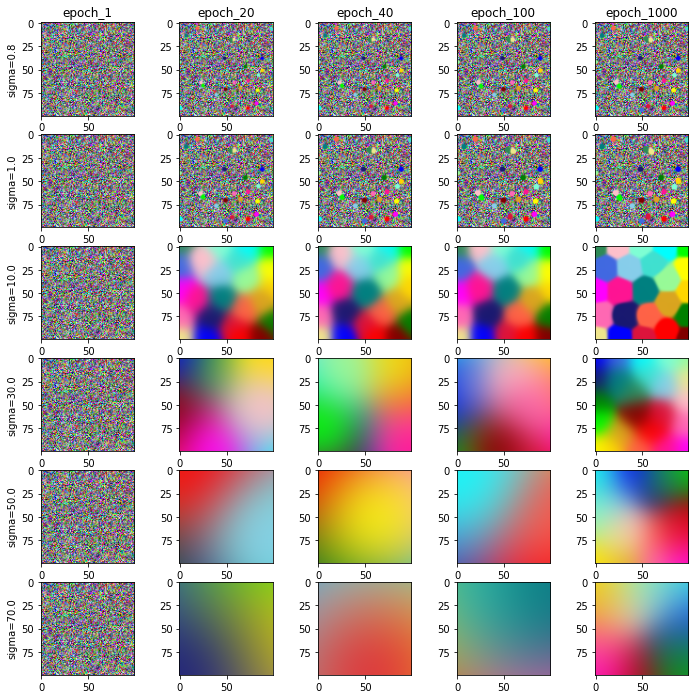

In [7]:
# Create the self organizing map given the following parameters of our data we wish to train and output
# Use parameters supplied by the assignment 4 to initialize it
n_input = 3 # 3 inputs since each value represents an RGB encoded valuea
n_output = 100

init_learn_rate = 0.8
init_neighborhood = 0.1
max_epochs = 1000

sigma_list = [0.8, 1, 10 ,30, 50, 70]
epoch_states = [0, 19, 39, 99, 999] # base 0

# Get a series of output maps for each sigma_list value and append the map to a resultant output weight map we store
# For later output and viewing.
plt.figure(figsize=(12,12))
for row, sigma in enumerate(sigma_list):
    #Generate an n_output x n_output (square) feature map
    som_map = SOM(n_input, n_output, init_learn_rate, sigma, max_epochs)

    #Train the Self organizing map on the data using the unsupervised model over a number of epochs
    weights = som_map.fit(training_data, epoch_states)

    for col, key in enumerate(weights):
        ind = col+1 + 5*row
        plt.subplot(len(sigma_list), len(epoch_states), ind)
        if col == 0:
            plt.ylabel('sigma=%.1f' % sigma)
        if row == 0:
            plt.title(key)
        plt.imshow(np.transpose(weights[key], [1, 2, 0]))
plt.show()

As sigma gets larger, the area affected by the neighbourhood update is larger. This is because the spread parameter is squared in the denominator of the neighbourhood update. This causes each update to affect a larger area, creating larger clusters. As we increase this value too much it begins to blur the lines between clusters of colours. With sigmas 0.8 and 1 our neighbourhoods are too small, so we still have noisy points that were not clustered because they were outside of the neighbourhood of the winning node.Sigmas 30, 50, and 70 had a spread that was too large, leading to a very blurry clustering. With sigma of 10 we start forming a set of boundaries fairly early into the training that continue to get further defined as the training continues. By 1000 epochs we have clear cut set of boundaries separating the 24 colour classes. In general, as the number of epochs increases, the SOM better clusters the inputs to the initial neighbourhoods that were found in earlier epochs. However, for tests with large sigma, the affected neighbourhood is so large that it can cause the weights to flip between classes, which is evident in sigma 70 going from epochs 20, 40, and 70.